In [147]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans



#Shrek6


In [148]:
column_name_mapping = {
    "filename": "Track_Name",
    "length": "Duration",
    "chroma_stft_mean": "Average_Note_Intensity",
    "chroma_stft_var": "Note_Intensity_Variability",
    "rms_mean": "Loudness_Average",
    "rms_var": "Loudness_Variability",
    "spectral_centroid_mean": "Brightness_Average",
    "spectral_centroid_var": "Brightness_Variability",
    "spectral_bandwidth_mean": "Sound_Richness_Average",
    "spectral_bandwidth_var": "Sound_Richness_Variability",
    "rolloff_mean": "Bass_to_Treble_Balance_Average",
    "rolloff_var": "Bass_to_Treble_Balance_Variability",
    "zero_crossing_rate_mean": "Percussiveness_Average",
    "zero_crossing_rate_var": "Percussiveness_Variability",
    "harmony_mean": "Harmonic_Content_Average",
    "harmony_var": "Harmonic_Content_Variability",
    "perceptr_mean": "Sharpness_Average",
    "perceptr_var": "Sharpness_Variability",
    "tempo": "Tempo",
    # MFCCs grouped
    **{f"mfcc{i}_mean": f"MFCC{i}_Average" for i in range(1, 21)},
    **{f"mfcc{i}_var": f"MFCC{i}_Variability" for i in range(1, 21)},
    "label": "Genre"
}


In [149]:
path = "D:/Coding/VS/Projects/Audio Genres/features_30_sec.csv/features_30_sec.csv"
data = pd.read_csv(path)

data_labeled = data.rename(columns=column_name_mapping)
data_labeled = data_labeled.drop(columns="Duration")
data_labeled.isnull().sum() 

scaler = StandardScaler()
le = LabelEncoder()

# Replace labels for rock and metal as they are often being confused + logically close
data_labeled["Genre"] = data_labeled["Genre"].replace({"rock": "rock_metal", "metal": "rock_metal"})


data_labeled["Genre"] = le.fit_transform(data_labeled["Genre"])


X = data_labeled.iloc[:, 1:-1]
y = data_labeled["Genre"]





In [150]:
genre_mapping = {index: label for index, label in enumerate(le.classes_)}
print("Encoded Labels:", genre_mapping)

Encoded Labels: {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'pop', 7: 'reggae', 8: 'rock_metal'}


In [ ]:
for col in data_labeled.columns[1:-1]:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data_labeled["Genre"], y=data_labeled[col])
    plt.title(f"Boxplot of {col} by Genre")
    plt.xlabel("Genre")
    plt.ylabel(col)
    plt.show()


In [ ]:
correlation_matrix = X.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm")


In [153]:

# Find highly correlated features
high_corr_pairs = np.where(((correlation_matrix > 0.9) | (correlation_matrix < -0.9)) & (correlation_matrix != 1.0))
correlated_features = [(correlation_matrix.index[x], correlation_matrix.columns[y]) for x, y in zip(*high_corr_pairs)]

correlated_features_df = pd.DataFrame(correlated_features, columns=['Feature 1', 'Feature 2'])
correlated_features_df

,Feature 1,Feature 2
0,Brightness_Average,Sound_Richness_Average
1,Brightness_Average,Bass_to_Treble_Balance_Average
2,Brightness_Average,MFCC2_Average
3,Sound_Richness_Average,Brightness_Average
4,Sound_Richness_Average,Bass_to_Treble_Balance_Average
5,Bass_to_Treble_Balance_Average,Brightness_Average
6,Bass_to_Treble_Balance_Average,Sound_Richness_Average
7,Bass_to_Treble_Balance_Average,MFCC2_Average
8,MFCC2_Average,Brightness_Average
9,MFCC2_Average,Bass_to_Treble_Balance_Average


In [154]:
X_uncor = X.drop(columns=['MFCC2_Average','Brightness_Average','Sound_Richness_Average' ])
X_uncor_scaled = scaler.fit_transform(X_uncor)

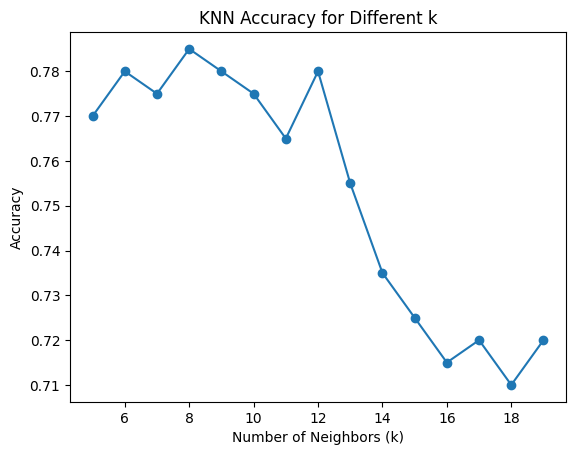

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_uncor_scaled, y, test_size=0.2, random_state=69, stratify=y) # stratify=y might lead to overfitting

k = range(5, 20)
accuracies = []

for i in k:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

plt.plot(k, accuracies, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy for Different k")
plt.show()

## the results are far from being good, let's try to add more hyperparameters

In [156]:
#Let's try to use GridSearchCV to find the best hyperparameters

param_grid = {
    'n_neighbors': list(range(1, 20)), 
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan']
}


knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_knn = grid_search.best_estimator_
y_pred_knn = best_knn.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy_score(y_test, y_pred_knn))

# Did not help much

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}
Test Accuracy: 0.73


In [157]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

knn_pca = KNeighborsClassifier()
grid_search_pca = GridSearchCV(knn_pca, param_grid, cv=5, scoring='accuracy')
grid_search_pca.fit(X_train_pca, y_train)

best_knn_pca = grid_search_pca.best_estimator_
y_pred_pca = best_knn_pca.predict(X_test_pca)

print("Best Parameters (PCA):", grid_search_pca.best_params_)
print("Test Accuracy (PCA):", accuracy_score(y_test, y_pred_pca))



Best Parameters (PCA): {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
Test Accuracy (PCA): 0.8


In [158]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Random Forest shows wore results than KNN so far, let's tune the hyperparameters

Random Forest Accuracy: 0.735
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.55      0.63        20
           1       0.91      1.00      0.95        20
           2       0.62      0.50      0.56        20
           3       0.71      0.50      0.59        20
           4       0.68      0.75      0.71        20
           5       0.84      0.80      0.82        20
           6       0.77      0.85      0.81        20
           7       0.70      0.70      0.70        20
           8       0.68      0.85      0.76        40

    accuracy                           0.73       200
   macro avg       0.74      0.72      0.72       200
weighted avg       0.73      0.73      0.73       200



In [180]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [200, 250, 300, 350, 500],        # Increase the number of trees
    'max_depth': [10, 15, 20],       # Allow deeper trees or no limit
    'min_samples_split': [2, 5, 10],       # Reduce regularization
    'min_samples_leaf': [1, 2 ,4]          # Allow smaller leaf sizes
}


grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print("Best Random Forest Parameters:", grid_search_rf.best_params_)

# we get the best estimators wit the given parameters


Best Random Forest Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [179]:
best_rf = grid_search_rf.best_estimator_ #taking best estimator from grid search
y_pred_best_rf = best_rf.predict(X_test)

print("Tuned Random Forest Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_best_rf))

# aaaaaand... it is worse than the non-tuned model. Not sure why tbh. To be checked later but I'm cool with it for now

Tuned Random Forest Accuracy: 0.725
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.55      0.69        20
           1       0.91      1.00      0.95        20
           2       0.75      0.60      0.67        20
           3       0.75      0.45      0.56        20
           4       0.60      0.60      0.60        20
           5       0.76      0.80      0.78        20
           6       0.71      0.85      0.77        20
           7       0.67      0.70      0.68        20
           8       0.65      0.85      0.74        40

    accuracy                           0.72       200
   macro avg       0.75      0.71      0.72       200
weighted avg       0.74      0.72      0.72       200



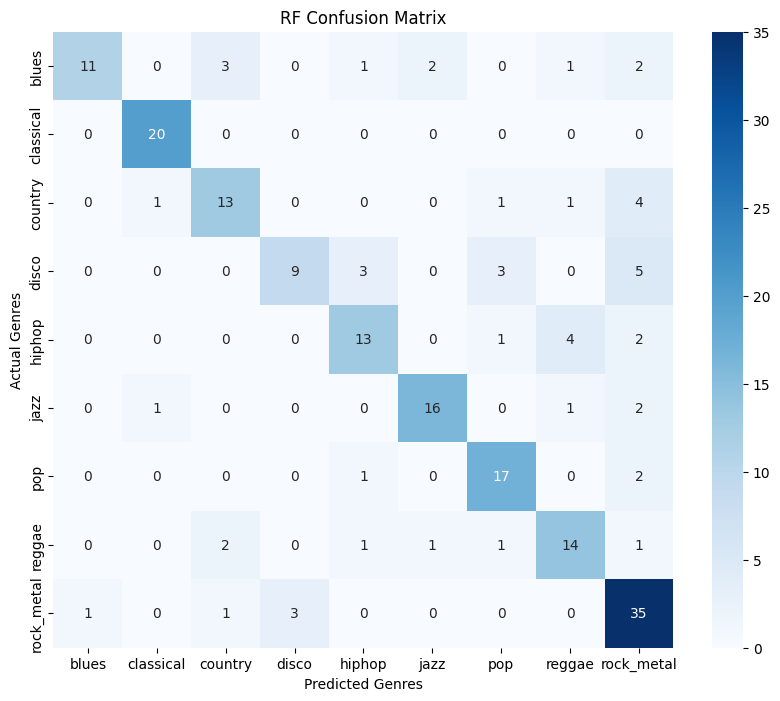

In [161]:
cm = confusion_matrix(y_test, y_pred_best_rf)  


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("RF Confusion Matrix")
plt.xlabel("Predicted Genres")
plt.ylabel("Actual Genres")
plt.show()


In [162]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf', random_state=42)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svc))
print("Classification Report:\n", classification_report(y_test, y_pred_svc))
 
# Sheesh, SVC is good, let's tune this hottie right here!


SVM Accuracy: 0.785
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.60      0.73        20
           1       0.91      1.00      0.95        20
           2       0.80      0.80      0.80        20
           3       0.75      0.45      0.56        20
           4       0.73      0.80      0.76        20
           5       0.81      0.85      0.83        20
           6       0.89      0.85      0.87        20
           7       0.74      0.70      0.72        20
           8       0.69      0.90      0.78        40

    accuracy                           0.79       200
   macro avg       0.80      0.77      0.78       200
weighted avg       0.79      0.79      0.78       200



In [163]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [ 1, 7, 10,15, 20],             # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001],     # Kernel coefficient
    'kernel': ['rbf', 'linear', 'poly'], # Types of kernel
    'degree': [1, 2, 3]                 # For polynomial kernel
}
# Initialize the SVM model
svm = SVC(probability=True, random_state=42)

# Grid search with cross-validation
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train_pca, y_train)

# Get the best model and parameters
best_svm = grid_search_svm.best_estimator_
print("Best Parameters:", grid_search_svm.best_params_)


Best Parameters: {'C': 15, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'}


In [164]:
# Predict on the test set
y_pred_svm = best_svm.predict(X_test_pca)

# Evaluate performance
from sklearn.metrics import classification_report, accuracy_score
print("Tuned SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))


Tuned SVM Accuracy: 0.83
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.95      1.00      0.98        20
           2       0.82      0.90      0.86        20
           3       0.71      0.75      0.73        20
           4       0.65      0.65      0.65        20
           5       0.89      0.85      0.87        20
           6       0.89      0.80      0.84        20
           7       0.71      0.60      0.65        20
           8       0.86      0.95      0.90        40

    accuracy                           0.83       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.83      0.83       200



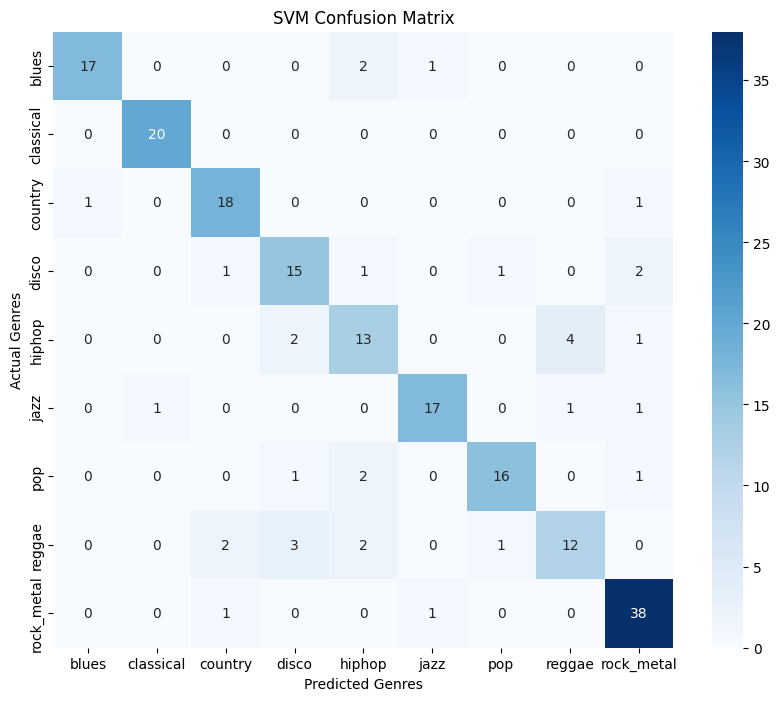

In [165]:
cm = confusion_matrix(y_test, y_pred_svm)  


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Genres")
plt.ylabel("Actual Genres")
plt.show()


In [166]:
from xgboost import XGBClassifier

# Train XGBoost
xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb.fit(X_train, y_train)

# Evaluate
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))


XGBoost Accuracy: 0.765


In [167]:

param_grid_xgb = {
    'n_estimators': [200, 300, 350],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.6, 0.8],

}

grid_search_xgb = GridSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='mlogloss'),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the grid search
grid_search_xgb.fit(X_train, y_train)

# Best estimator and parameters
best_xgb = grid_search_xgb.best_estimator_
print("Best XGBoost Parameters:", grid_search_xgb.best_params_)


Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}


In [168]:
# Predict on test set
y_pred_best_xgb = best_xgb.predict(X_test)

# Evaluate performance
print("Tuned XGBoost Accuracy:", accuracy_score(y_test, y_pred_best_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_best_xgb))


Tuned XGBoost Accuracy: 0.81
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.70      0.80        20
           1       0.95      1.00      0.98        20
           2       0.78      0.90      0.84        20
           3       0.87      0.65      0.74        20
           4       0.70      0.80      0.74        20
           5       0.94      0.85      0.89        20
           6       0.84      0.80      0.82        20
           7       0.71      0.60      0.65        20
           8       0.73      0.90      0.81        40

    accuracy                           0.81       200
   macro avg       0.83      0.80      0.81       200
weighted avg       0.82      0.81      0.81       200



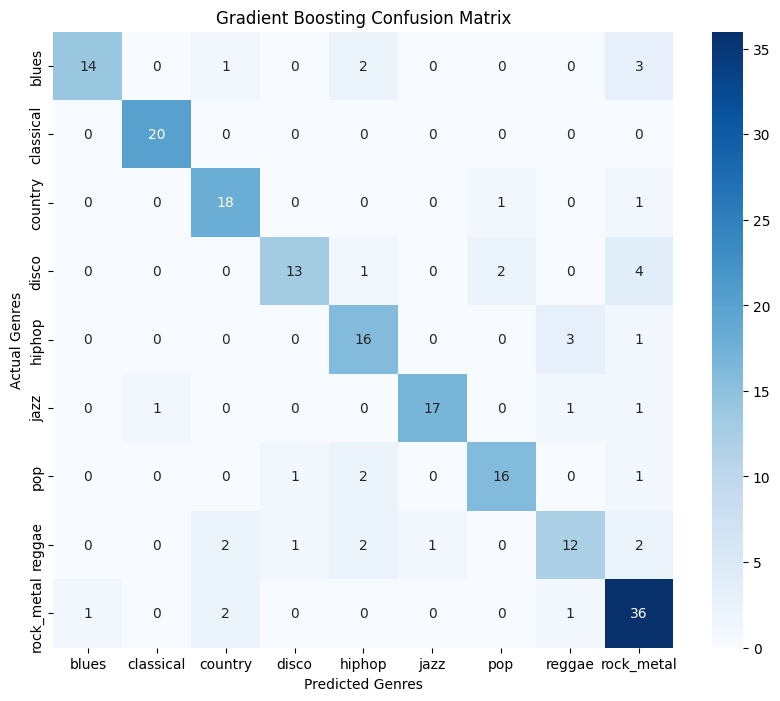

In [169]:
cm = confusion_matrix(y_test, y_pred_best_xgb)  


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Gradient Boosting Confusion Matrix")
plt.xlabel("Predicted Genres")
plt.ylabel("Actual Genres")
plt.show()


In [193]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('svc', best_svm)
], voting='soft', weights=[1, 2, 3])

ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)

print("Ensemble Accuracy:", accuracy_score(y_test, y_pred_ensemble))



Ensemble Accuracy: 0.835


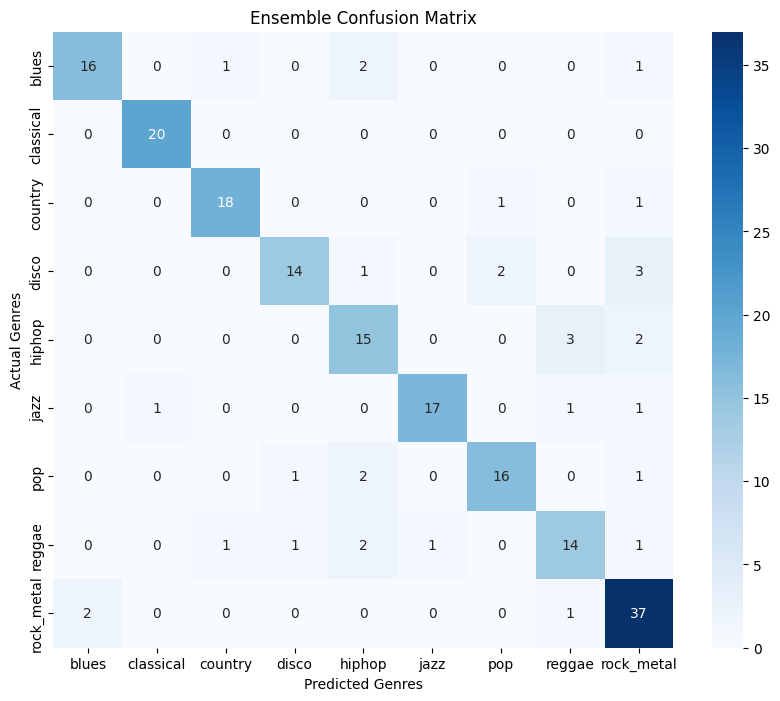

In [194]:
cm = confusion_matrix(y_test, y_pred_ensemble)  

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Ensemble Confusion Matrix")
plt.xlabel("Predicted Genres")
plt.ylabel("Actual Genres")
plt.show()
